# Aggregate estimation from gravity model

First we are going to make some imports

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import numpy as np
import pickle

Finding the repository we are working in so later is easier to read/write files

In [3]:
dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')
print(data_path)

/scratch/cs/networks/heydars1/mobility-visualizations-finland/covid_population_flow/data


In [5]:
m_to_h_data_converted_format = os.path.join(data_path, 'kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv')

/scratch/cs/networks/heydars1/mobility-visualizations-finland/covid_population_flow/data/kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv
utf-8


'utf-8'

This function will read the file `kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv` and generate 2 dictionaries. The first one will map the hospital care districts (HCD) to the municipalities. The second one will do the inverse order.

In [6]:
def map_municiplaities_to_hospital_district_areas(data_path):
    line_counter = 0
    m_to_h = {}
    h_to_m = {}
    with open(data_path, 'r') as data:
        for line in data:
            line_counter += 1
            ### the enteries start from 6th line
            if line_counter > 5:
                fields = line.strip().split(';')
                municipality_string = fields[1]
                #print(municipality_string)
                municipality = municipality_string[1:-1]
                #print(municipality)
                hospital_string = fields[3]
                hospital_district = hospital_string[1:-1]
                #print(hospital_district)
                m_to_h[municipality] = hospital_district
                if hospital_district not in h_to_m.keys():
                    h_to_m[hospital_district] = set()
                h_to_m[hospital_district].add(municipality)
    return h_to_m, m_to_h

Storing the results of running the function

In [7]:
h_to_m, m_to_h = map_municiplaities_to_hospital_district_areas(m_to_h_data_converted_format)
# print(h_to_m)
# print(m_to_h)

# Gravity Model
The path for results of gravity model in municipality level. The results are produced by the script at dynamic-mobility/gravity_models_v1.1.ipynb
Next we want to aggregate these estimates in hospital district level

In [8]:
gravity_result_commuters = os.path.join(dir_path, 'results/gravity_model_exp_avg_surface_with_commuter.csv')

The following function aggregates flows predicted by gravity model in hospital care district level

In [9]:
def calculate_flow_between_hospital_district_from_gravity_model_predictions(gravity_model_results_path, municipality_to_hospital_district_book):
    #Gravity model estimates number of work-commuters between provinces. In here we assume that every communter commutes EVERY DAY to calculate a baseline
    hospital_district_level_gravity = {}
    with open(gravity_model_results_path, 'r') as data:
        next(data)
        for line in data:
            fields = line.strip().split(",")
            origin_m = fields[0]
            destination_m = fields[1]
            prediction = float(fields[2])
            if origin_m in municipality_to_hospital_district_book.keys() and destination_m in municipality_to_hospital_district_book.keys():
                origin_h = municipality_to_hospital_district_book[origin_m]
                destination_h = municipality_to_hospital_district_book[destination_m]
                if (origin_h, destination_h) not in hospital_district_level_gravity:
                    hospital_district_level_gravity[(origin_h, destination_h)] = 0
                hospital_district_level_gravity[(origin_h, destination_h)] += prediction
    return hospital_district_level_gravity

In [10]:
hospital_gravity_prediction_commuters = calculate_flow_between_hospital_district_from_gravity_model_predictions(gravity_result_commuters, m_to_h)
print(hospital_gravity_prediction_commuters[('Helsinki and Uusimaa Hospital District', 'Kanta-Häme Hospital District')])
# Store data (serialize)
with open((os.path.join(dir_path, 'results/gravity_model_commuters_hcd.pickle')), 'wb') as handle:
    pickle.dump(hospital_gravity_prediction_commuters, handle, protocol=pickle.HIGHEST_PROTOCOL)

3858.0


In [11]:
hospital_gravity_prediction_commuters

{('Helsinki and Uusimaa Hospital District',
  'Helsinki and Uusimaa Hospital District'): 316150.0,
 ('Southwest Finland Hospital District',
  'Southwest Finland Hospital District'): 77062.0,
 ('Pirkanmaa Hospital District', 'Pirkanmaa Hospital District'): 77032.0,
 ('North Savo Hospital District', 'North Savo Hospital District'): 21752.0,
 ('North Ostrobothnia Hospital District',
  'North Ostrobothnia Hospital District'): 36226.0,
 ('Central Finland Hospital District',
  'Central Finland Hospital District'): 23823.0,
 ('Vaasa Hospital District', 'Vaasa Hospital District'): 20057.0,
 ('Päijät-Häme Hospital District', 'Päijät-Häme Hospital District'): 20427.0,
 ('North Karelia Hospital District',
  'North Karelia Hospital District'): 15682.0,
 ('Satakunta Hospital District', 'Satakunta Hospital District'): 22098.0,
 ('South Karelia Hospital District',
  'South Karelia Hospital District'): 10750.0,
 ('Kymenlaakso Hospital District', 'Kymenlaakso Hospital District'): 9904.0,
 ('South Ostro

# Radiation model

In [12]:
def calculate_flow_between_hospital_district_from_radiation_model_predictions(radiation_model_results_path, municipality_to_hospital_district_book):
    #Radiation model estimates number of work-commuters between provinces. In here we assume that every communter commutes EVERY DAY to calculate a baseline
    hospital_district_level_radiation = {}
    with open(radiation_model_results_path, 'r') as data:
        next(data)
        for line in data:
            fields = line.strip().split(",")
            origin_m = fields[0]
            destination_m = fields[1]
            prediction = float(fields[6])
            if origin_m in municipality_to_hospital_district_book.keys() and destination_m in municipality_to_hospital_district_book.keys():
                origin_h = municipality_to_hospital_district_book[origin_m]
                destination_h = municipality_to_hospital_district_book[destination_m]
                if (origin_h, destination_h) not in hospital_district_level_radiation:
                    hospital_district_level_radiation[(origin_h, destination_h)] = 0
                hospital_district_level_radiation[(origin_h, destination_h)] += prediction
    return hospital_district_level_radiation

In [13]:
radiation_result_municipality_level = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/covid_population_flow/results/results_updated_radiation_model_with_total_num_outcommuters_as_a_prior.csv"

In [14]:
hospital_radiation_prediction_commuters = hospital_radiation_prediction = calculate_flow_between_hospital_district_from_radiation_model_predictions(radiation_result_municipality_level, m_to_h)
print(hospital_radiation_prediction_commuters[('Helsinki and Uusimaa Hospital District', 'Kanta-Häme Hospital District')])
with open((os.path.join(dir_path, 'results/radiation_model_commuters_hcd.pickle')), 'wb') as handle:
    pickle.dump(hospital_radiation_prediction_commuters, handle, protocol=pickle.HIGHEST_PROTOCOL)

9605.95409117736


In [15]:
def calculate_out_and_in_signatures(results_book, ego_region):
    regions = set([o for (o,d) in results_book.keys()])
    #make sure that the matrix is full (has an entry for all the (o,d) pairs)
    for o in regions:
        for d in regions:
            if (o,d) not in results_book.keys():
                results_book[(o,d)] = 0
    
    
    #the fractions excluding inside-region mobility
    incomming_frac_book = {}
    outgoing_frac_book = {}
    sum_incomming = {}
    sum_outgoing = {}
    for (origin, destination) in results_book.keys():
        if origin != destination:
            value = results_book[(origin, destination)]
            if origin not in sum_outgoing.keys():
                sum_outgoing[origin] = 0
            sum_outgoing[origin] += value
            if destination not in sum_incomming.keys():
                sum_incomming[destination] = 0
            sum_incomming[destination] += value
    
    out_sig_book = dict()
    in_sig_book = dict()
    for d in regions:
        if ego_region != d:
            out_sig_book[d] = results_book[(ego_region, d)] / sum_outgoing[ego_region]
    for o in regions:
        if ego_region != o:
            in_sig_book[o] = results_book[(o, ego_region)] / sum_incomming[ego_region]
    #print(out_sig_book)
    #print(sum(out_sig_book.values()))
    #print(in_sig_book)
    #print(sum(in_sig_book.values()))
    return(out_sig_book, in_sig_book)      

In [16]:
out_sig_gravity, in_sig_gravity = calculate_out_and_in_signatures(hospital_gravity_prediction_commuters, 'Helsinki and Uusimaa Hospital District')

In [17]:
out_sig_radiation, in_sig_radiation = calculate_out_and_in_signatures(hospital_radiation_prediction_commuters, 'Helsinki and Uusimaa Hospital District')

In [18]:
out_sig_radiation_list = sorted(list(out_sig_radiation.items()), key=lambda tup: tup[1], reverse = True )
in_sig_radiation_list = sorted(list(in_sig_radiation.items()), key=lambda tup: tup[1], reverse = True )
out_sig_gravity_list = sorted(list(out_sig_gravity.items()), key=lambda tup: tup[1], reverse = True )
in_sig_gravity_list = sorted(list(in_sig_gravity.items()), key=lambda tup: tup[1], reverse = True )

In [19]:
#out_sig_radiation_list

In [20]:
#out_sig_gravity_list

In [21]:
short_labels_map = {'North Ostrobothnia Hospital District': 'North Ostrobothnia',
 'Southwest Finland Hospital District': 'Southwest Finland',
 'Pirkanmaa Hospital District': 'Pirkanmaa',
 'Central Finland Hospital District': 'Central Finland',
 'North Savo Hospital District':'North Savo',
 'South Ostrobothnia Hospital District':'South Ostrobothnia',
 'Satakunta Hospital District':'Satakunta',
 'Åland':'Åland',
 'Lappi Hospital District':'Lappi',
 'Vaasa Hospital District': 'Vaasa',
 'North Karelia Hospital District': 'North Karelia',
 'Päijät-Häme Hospital District': 'Päijät-Häme',
 'Kanta-Häme Hospital District':'Kanta-Häme',
 'Central Ostrobothnia Hospital District':'Central Ostrobothnia',
 'South Savo Hospital District':'South Savo',
 'South Karelia Hospital District':'South Karelia',
 'Kainuu Hospital District':'Kainuu',
 'Länsi-Pohja Hospital District':'Länsi-Pohja',
 'Kymenlaakso Hospital District':'Kymenlaakso',
 'Itä-Savo Hospital District':'Itä-Savo'}

<ipython-input-39-b6e020b9378f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20)
<ipython-input-39-b6e020b9378f>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20)
<ipython-input-39-b6e020b9378f>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20)
<ipython-input-39-b6e020b9378f>:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20)


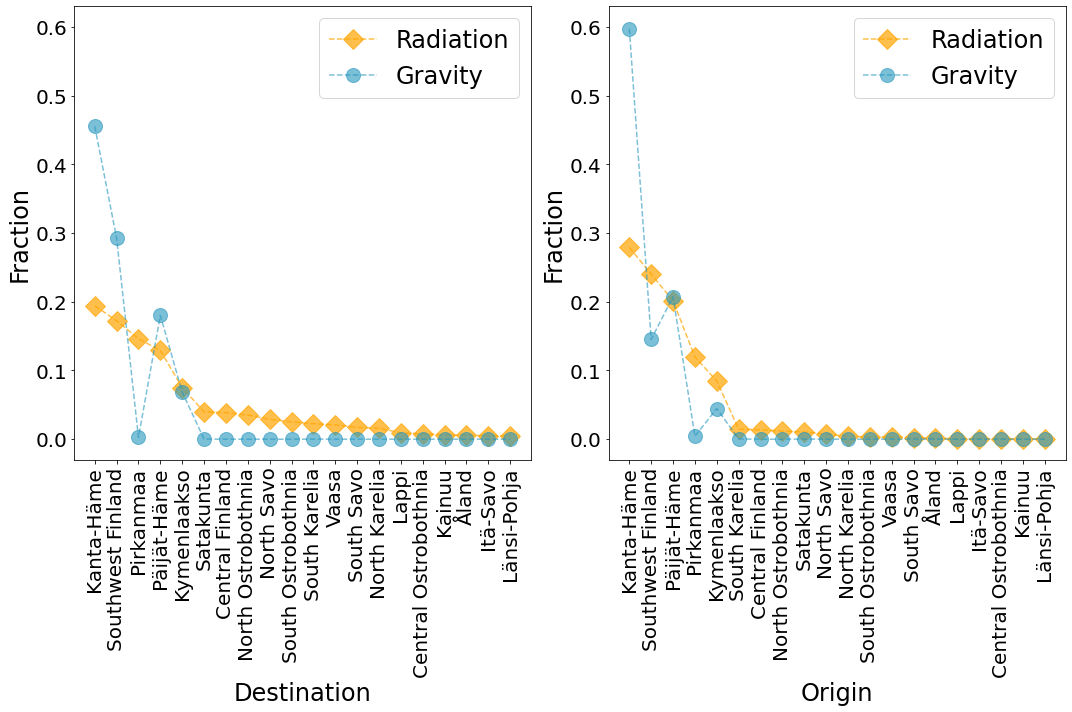

In [39]:
label_list, radiation_fraction_list = map(list, zip(*out_sig_radiation_list))
label_list_shortened = [short_labels_map[label] for label in label_list]
gravity_fraction_list = [out_sig_gravity[region] for region in label_list]
#plt.plot(label_list_shortened, fraction_list, ls = "--", marker = "o")
f = plt.figure(figsize = (15,10))
ax = f.add_subplot(1,2,1)
ax.plot(label_list_shortened, radiation_fraction_list, ls = "--", marker = "D", color = "orange", alpha = 0.7, label = "Radiation", markersize = 14)
ax.plot(label_list_shortened, gravity_fraction_list, ls = "--", marker = "o", color = "#2596be", alpha = 0.6, label = "Gravity", markersize = 14)
ax.set_ylabel("Fraction", fontsize = 24)
ax.set_xlabel("Destination", fontsize = 24)
ax.set_ylim(-0.03, 0.63)
ax.tick_params(axis="y", labelsize=20)
ax.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20) 
#plt.xticks()
ax.legend(fontsize = 24)

label_list, radiation_fraction_list = map(list, zip(*in_sig_radiation_list))
label_list_shortened = [short_labels_map[label] for label in label_list]
gravity_fraction_list = [in_sig_gravity[region] for region in label_list]
#plt.plot(label_list_shortened, fraction_list, ls = "--", marker = "o")
ax1 = f.add_subplot(1,2,2)
ax1.plot(label_list_shortened, radiation_fraction_list, ls = "--", marker = "D", color = "orange", alpha = 0.7, label = "Radiation", markersize = 14)
ax1.plot(label_list_shortened, gravity_fraction_list, ls = "--", marker = "o", color = "#2596be", alpha = 0.6, label = "Gravity", markersize = 14)
ax1.set_ylabel("Fraction", fontsize = 24)
ax1.set_xlabel("Origin", fontsize = 24)
ax1.tick_params(axis="y", labelsize=20)
ax1.set_xticklabels(label_list_shortened, Rotation = 90, fontsize = 20)
ax1.set_ylim(-0.03, 0.63)
#plt.xticks()
ax1.legend(fontsize = 24)

plt.tight_layout()
plt.savefig('./results/plots/fig1.pdf')
plt.savefig('./results/plots/fig1.png', dpi=300)